In [40]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import time

In [41]:
def get_dlu_summands(A):
    """
    Splits A into its diagonal, lower triangular (without diag) and upper triagonal (without diag) matrix, i.e.
    A = D + L + U
    
    Be careful, this is NOT!!! an ldu factorization!
    
    """
    D = np.diag(np.diag(A))
    L = np.tril(A, -1)
    U = np.triu(A, 1)
    assert(np.all(D + L + U == A))
    return D, L, U

# D, L, U = get_dlu_summands(A)
# print("D = \n", D, "\nL =\n", L, "\nU = \n", U)

# D + L + U

In [42]:
def get_Tj(A):
    """
    Returns the Jacobi iteration matrix of A
    """
    D, L, U = get_dlu_summands(A)
    return np.linalg.inv(D) @ (-L-U)

def get_Tgs(A):
    """
    Returns the Gauss-Seidel iteration matrix of A
    """
    D, L, U = get_dlu_summands(A)
    return - np.linalg.inv(D + L) @ U

def get_Tsor(A, w):
    """
    Returns the Successive Over-Relaxation iteration matrix of A 
    for given weighting w bw. old and new Gauss-Seidel vectors
    """
    D, L, U = get_dlu_summands(A)
    return np.linalg.inv(D + w*L) @ (-w*U + (1-w)*D)

# Get iteration matrix and spectral radius for Jacobi Method
# Tj = get_Tj(A)
# spectral_radius = get_spectral_radius(Tj)
# print("spectral radius of Tj = ", spectral_radius)
# print("convergence: ", spectral_radius < 1, "\n")

# Get iteration matrix and spectral radius for Gauss-Seidel Method
# Tgs = get_Tgs(A)
# spectral_radius = get_spectral_radius(Tgs)
# print("spectral radius of Tgs = ", spectral_radius)
# print("convergence: ", spectral_radius < 1, "\n")
    

In [43]:
def get_spectral_radius(T):
    """Return the spectral radius, i.e. the max. abs. eigenvalue of the input matrix"""
    eigvals = np.linalg.eigvals(T)
    return np.max(abs(eigvals)) # remember to compare the absolute value of the eigenvalues!

In [44]:
A1 = np.array([[3, 0, 4], [7, 4, 2], [-1, 1, 2]])
A2 = np.array([[-3, 3, -6], [-4, 7, -8], [5, 7, -9]])
A3 = np.array([[4, 1, 1], [2, -9, 0], [0, -8, -6]])
A4 = np.array([[7, 6, 9], [4, 5, -4], [-7, -3, 8]])
A5 = np.array([[3, 2, 1], [2, 3, 2], [1, 2, 3]])

In [45]:
# Check if Jacobi and Gauss-Seidel Method converge for given matrices A1 - A4
for a in [A1, A2, A3, A4]:
    Tj = get_Tj(a)
    spectral_radius = get_spectral_radius(Tj)
    print("spectral radius of Tj = ", spectral_radius)
    print("convergence: ", spectral_radius < 1, "\n")

for a in [A1, A2, A3, A4]:
    Tgs = get_Tgs(a)
    spectral_radius = get_spectral_radius(Tgs)
    print("spectral radius of Tgs = ", spectral_radius)
    print("convergence: ", spectral_radius < 1, "\n")

spectral radius of Tj =  1.12514735635261
convergence:  False 

spectral radius of Tj =  0.8133091054692767
convergence:  True 

spectral radius of Tj =  0.4438188250156999
convergence:  True 

spectral radius of Tj =  0.641132809955697
convergence:  True 

spectral radius of Tgs =  1.5833333333333335
convergence:  False 

spectral radius of Tgs =  1.1111111111111107
convergence:  False 

spectral radius of Tgs =  0.018518518518518517
convergence:  True 

spectral radius of Tgs =  0.7745966692414834
convergence:  True 



min. spectral radius =  0.33848706746672824
w_opt = 1.151


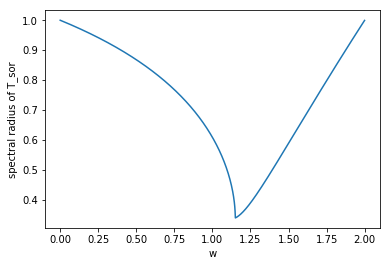

In [46]:
# Successive Overrelaxation method: 
# plot the spectral radius as a function of w, 0 < w < 2
w = np.arange(0.001, 2, 0.001) # weights
p = np.zeros(len(w)) # empty array for spectral radius
for i in range(len(w)):
    Tsor = get_Tsor(A5, w[i])
    spectral_radius = get_spectral_radius(Tsor)
    p[i] = spectral_radius

plt.plot(w, p)
plt.xlabel("w")
plt.ylabel("spectral radius of T_sor")
None

print("min. spectral radius = ", np.min(p))
print("w_opt =", w[np.argmin(p)]) # Optimal value of w for fast convergence

In [47]:
# Find minimum number of SOR iterations to achieve ATOL for different w
# |ek| = |e0| * |Tk|**k = ATOL --> k = log10(ATOL) / log10(spectral radius of T)
ATOL = 1e-10
def get_k(T, ATOL):
    p = get_spectral_radius(T)
    k = np.log10(ATOL) / np.log10(p)
    return k

w    = 0.4
Tsor = get_Tsor(A5, w)
k    = get_k(Tsor, ATOL)
print("min. iterations to reach ATOL for w = ",w, ": ", np.ceil(k) )

w    = 1.4
Tsor = get_Tsor(A5, w)
k    = get_k(Tsor, ATOL)
print("min. iterations to reach ATOL for w = ",w, ": ", np.ceil(k) )

min. iterations to reach ATOL for w =  0.4 :  219.0
min. iterations to reach ATOL for w =  1.4 :  34.0


In [48]:
# The smaller the norm of T or the spectral radius, the faster the iterative converges.

In [49]:
def jacobi_method(A, b, x0, RTOL, ATOL):
    start_time = time.time()
    T  = get_Tj(A)
    p  = get_spectral_radius(T)
    print("p(Tj) = ", p)
    D, L, U = get_dlu_summands(A)
    
    if(p >= 1.0):
        print("Apectral radius of Tj = ", spectral_radius, ". \nThus, the Jacobi Method will not converge for the given A.")
        return 1
    
    repeat = 1
    i = 0
    while(repeat):
        i += 1
        c  = np.linalg.inv(D) @ b
        x  = T @ x0 + c
        if all((abs(x - x0)) <= RTOL* abs(x) + ATOL):
            repeat = 0
            print("After ", i, "iterations converged to x = ", x0)
            print("CPU time: %s seconds" % (time.time() - start_time))
            return x
        
        else: x0 = x

In [50]:
A  = np.array([[5, 2, 1], [4, 11, 5], [7, 8, 16]])
b  = np.array([8, 20, 31])
x0 = [0.5, 0.5, 0.5]

RTOL = 1e-12
ATOL = 1e-12

In [51]:
x = jacobi_method(A, b, x0, RTOL, ATOL)

p(Tj) =  0.7802448571464132
After  110 iterations converged to x =  [1. 1. 1.]
CPU time: 0.008398056030273438 seconds


In [52]:
A@x

array([ 8., 20., 31.])

In [53]:
x

array([1., 1., 1.])

In [54]:
def gauss_seidel_method(A, b, x0, RTOL, ATOL):
    start_time = time.time()
    T  = get_Tgs(A)
    p  = get_spectral_radius(T)
    print("p(Tgs) = ", p)
    D, L, U = get_dlu_summands(A)
    
    if(p >= 1.0):
        print("Spectral radius of Tgs = ", spectral_radius, ". \nThus, the Gauss-Seidel Method will not converge for the given A.")
        return 1
    
    repeat = 1
    i = 0
    while(repeat):
        i += 1
        c  = np.linalg.inv(D + L) @ b
        x  = T @ x0 + c
        if all((abs(x - x0)) <= RTOL* abs(x) + ATOL):
            repeat = 0
            print("After ", i, "iterations converged to x = ", x0)
            print("CPU time: %s seconds" % (time.time() - start_time))
            return x
        
        else: x0 = x

In [55]:
A  = np.array([[5, 2, 1], [4, 11, 5], [7, 8, 16]])
b  = np.array([8, 20, 31])
x0 = [0.5, 0.5, 0.5]

RTOL = 1e-12
ATOL = 1e-12

In [56]:
x = gauss_seidel_method(A, b, x0, RTOL, ATOL)

p(Tgs) =  0.28203803740888317
After  23 iterations converged to x =  [1. 1. 1.]
CPU time: 0.003736734390258789 seconds


In [57]:
A@x

array([ 8., 20., 31.])

In [61]:
def sor_method(A, b, x0, w, RTOL, ATOL):
    start_time = time.time()
    T  = get_Tsor(A, w)
    p  = get_spectral_radius(T)
    print("p(Tsor) = ", p)
    D, L, U = get_dlu_summands(A)
    
    if(p >= 1.0):
        print("Spectral radius of Tsor = ", spectral_radius, ". \nThus, the Gauss-Seidel Method will not converge for the given A.")
        return 1
    
    repeat = 1
    i = 0
    while(repeat):
        i += 1
        c  = np.linalg.inv(D + w*L) * w @ b
        x  = T @ x0 + c
        if all((abs(x - x0)) <= RTOL* abs(x) + ATOL):
            repeat = 0
            print("After ", i, "iterations converged to x = ", x0)
            print("CPU time: %s seconds" % (time.time() - start_time))
            return x
        
        else: x0 = x

min. spectral radius =  0.2731780361936815
w_opt = 1.043


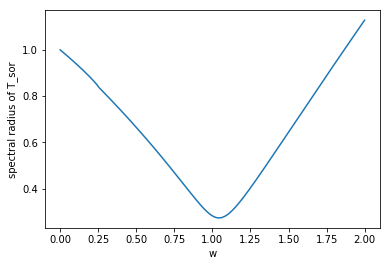

In [62]:
# Successive Overrelaxation method: 
# plot the spectral radius as a function of w, 0 < w < 2
w = np.arange(0.001, 2, 0.001) # weights
p = np.zeros(len(w)) # empty array for spectral radius
for i in range(len(w)):
    Tsor = get_Tsor(A, w[i])
    spectral_radius = get_spectral_radius(Tsor)
    p[i] = spectral_radius

plt.plot(w, p)
plt.xlabel("w")
plt.ylabel("spectral radius of T_sor")
None

# Find the optimal weight
w_opt = w[np.argmin(p)]
print("min. spectral radius = ", np.min(p))
print("w_opt =", w[np.argmin(p)]) # Optimal value of w for fast convergence

In [63]:
# p_tj = get_spectral_radius(get_Tj(A))
# w = 2 / (1 + np.sqrt(1 - p_tj)**2) 
sor_method(A, b, x0, w_opt, RTOL, ATOL)

p(Tsor) =  0.2731780361936815
After  23 iterations converged to x =  [1. 1. 1.]
CPU time: 0.0029778480529785156 seconds


array([1., 1., 1.])